In [1]:
import os

# Set before any torch.cuda.* calls
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed: int):
    # 1. Python built-in random module
    random.seed(seed)
    # 2. NumPy random numbers
    np.random.seed(seed)
    # 3. PyTorch CPU random numbers
    torch.manual_seed(seed)
    # 4. PyTorch GPU random numbers (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # 5. Ensure reproducible convolution algorithms (disable cuDNN auto-tuner)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # 6. Force deterministic algorithms for all APIs (PyTorch ≥ 1.8)
    try:
        torch.use_deterministic_algorithms(True)
    except AttributeError:
        pass
    # 7. Optional: Remove potential non-determinism in hashing
    os.environ["PYTHONHASHSEED"] = str(seed)

# Example usage
RandSeed = 42
set_seed(RandSeed)


In [2]:
# Import modules

%matplotlib notebook
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from SAGE_model import SeismicDataset1, SeismicDataset2, GraphNet 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import shutil

In [3]:
# Define the data directories

model_name = "DA_max-aggregate2_dropout=0.15+Gaussian"

cwd = os.path.dirname(os.getcwd())  # Get the parent directory of the current working directory
data_dir = os.path.join(cwd, "data_DA")
processed_waveform_dir = os.path.join(data_dir, "waveforms_proc_broadband")


# Data preparation

In [4]:
# Fix random seed for reproducibility
# np.random.seed(0)

# Data ranges (min/max)
minlatitude = 32
maxlatitude = 36
minlongitude = -120
maxlongitude = -116
maxdepth = 30e3
minmag = 3
maxmag = 6

# Fraction of the data to be used in training
split = 0.8

As part of the data preparation process, we scale the data within the range of $\pm 1$, and split the data set into a training set and a validation set.

In [5]:
# Get the event catalogue
catalogue = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))[["lat", "lon", "depth", "mag"]]

# Check which events have data
for i, event in catalogue.iterrows():
    # Event data file
    cat_file = os.path.join(processed_waveform_dir, "%d.npy" % i)
    # If file not exists: remove event from catalogue0
    if not os.path.isfile(cat_file):
        catalogue.drop(index=i, inplace=True)

# Print number of events
print(len(catalogue))        

# Event identifiers
ids = catalogue.index.values
# Uniform weights
weights = np.ones((len(ids), 1))
# Event lat/lon/depth/magnitude
catalogue = catalogue.values

# Scale data
catalogue[:, 0] = (catalogue[:, 0] - minlatitude) / (maxlatitude - minlatitude)
catalogue[:, 1] = (catalogue[:, 1] - minlongitude) / (maxlongitude - minlongitude)
catalogue[:, 2] = catalogue[:, 2] / maxdepth
catalogue[:, 3] = (catalogue[:, 3] - minmag) / (maxmag - minmag)

catalogue = (catalogue - 0.5) * 2

# Concatenate identifiers and weights to event data
catalogue = np.concatenate([ids.reshape(-1, 1), weights.reshape(-1, 1), catalogue], axis=1)

# Randomly split events into train and validation sets
inds = np.arange(catalogue.shape[0])
np.random.shuffle(inds)
N_split = int(split * catalogue.shape[0])

train_inds = inds[:N_split]
test_inds = inds[N_split:]

# Split catalogue
train_catalogue = catalogue[train_inds]
test_catalogue = catalogue[test_inds]

# Check data distributions to ensure that train and validation sets are similar!
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
# axes = axes.ravel()

# for i in range(4):
#     ax = axes[i]
#     ax.hist(catalogue[:, i+2], bins=20, density=False)
#     ax.hist(train_catalogue[:, i+2], bins=20, alpha=0.5, density=False)
#     ax.hist(test_catalogue[:, i+2], bins=20, alpha=0.5, density=False)

# plt.tight_layout()    
# plt.show()

2533


In [6]:
# Load station information
stations = pd.read_csv(os.path.join(data_dir, "stations.csv"))[["code", "lat", "lon"]]

# Normalize latitude and longitude to the range [-1, 1]
stations["lat"] = ((stations["lat"] - minlatitude) / (maxlatitude - minlatitude) - 0.5) * 2
stations["lon"] = ((stations["lon"] - minlongitude) / (maxlongitude - minlongitude) - 0.5) * 2

In [7]:
# Open the event-station lookup file
lookup_file = os.path.join(data_dir, "catalogue_station_lookup_final.pickle")

with open(lookup_file, "rb") as f:
    lookup = pickle.load(f)

In [8]:
from torch.utils.data import DataLoader

# Set parameters
N_sub = 50
N_t = 2048

train_dataset = SeismicDataset2(
    data_dir=processed_waveform_dir,
    catalogue=train_catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
)

test_dataset = SeismicDataset1(
    data_dir=processed_waveform_dir,
    catalogue=test_catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
    worker_init_fn=lambda worker_id: np.random.seed(RandSeed + worker_id))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
import os

# Automatically determine the current execution context (script or notebook)
# and create a corresponding save directory for model checkpoints.
try:
    # Case 1: Running as a .py script
    base_name = os.path.splitext(os.path.basename(__file__))[0]
except NameError:
    # Case 2: Running inside a Jupyter notebook (no __file__ available)
    try:
        # Try to get the notebook name via ipynbname
        import ipynbname
        base_name = ipynbname.name()
    except Exception:
        # Fallback to a generic name if detection fails
        base_name = "notebook"

# Create a dedicated subdirectory under "save/" based on the current context name
model_name = f"{base_name}_DA_max-aggregate2_dropout=0.15+Gaussian"

savedir = os.path.join("save", model_name)
os.makedirs(savedir, exist_ok=True)

# Define checkpoint file paths
savefile_best = os.path.join(savedir, "best-model.pth")
savefile_last = os.path.join(savedir, "last-model.pth")

# Initialize tracking for the best validation loss
best_val_loss = float("inf")
# …


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== model ==========
model = GraphNet(activation="relu").to(device)

# ========== optimizer / criterion ==========
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 同 model.LR
criterion = nn.L1Loss()  # MAE = Mean Absolute Error

best_val_loss = float("inf")


# ========== Training Loop ==========
num_epochs = 50
no_improve_epoch = 50
epoch = 0
no_improve_count = 0

train_loss_list = []
val_loss_list = []
# Assign different loss weights to the four tasks (the 4th task has a lower weight)

loss_weights = torch.tensor([1.0, 1.0, 0.3, 0.1], device=device)  

train_flag = 1
lr_change = 0

while train_flag == 1:
    # If the training has reached the specified number of epochs, and there has been no improvement
    # for a certain number of consecutive epochs, reduce the learning rate.
    if epoch > num_epochs and no_improve_count > no_improve_epoch:
        if lr_change == 0:
            # Change learning rate to a lower value (2e-5) and reset improvement counter
            optimizer = optim.Adam(model.parameters(), lr=2e-5)
            no_improve_count = 0
            lr_change = 1
        else:
            # Stop training if learning rate has already been reduced
            train_flag = 0
    model.train()
    train_loss = 0
    for (waveforms, coords, weights), labels, _ in tqdm(train_loader):
        waveforms, coords, weights, labels = (
            waveforms.to(device),
            coords.to(device),
            weights.to(device),
            labels.to(device),
        )

        optimizer.zero_grad()
        preds = model(waveforms, coords, weights)
        loss_per_dim = torch.abs(preds - labels)    # (B,4)
        weighted_loss = loss_per_dim * loss_weights      # (B,4)
        loss = weighted_loss.mean()   
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ======== Validation ========
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (waveforms, coords, weights), labels, _ in test_loader:
            waveforms, coords, weights, labels = (
                waveforms.to(device),
                coords.to(device),
                weights.to(device),
                labels.to(device),
            )
            preds = model(waveforms, coords, weights)
            loss_per_dim = torch.abs(preds - labels)    # (B,4)
            weighted_loss = loss_per_dim * loss_weights      # (B,4)
            loss = weighted_loss.mean()   
            val_loss += loss.item()

    val_loss /= len(test_loader)

    print(f"[Epoch {epoch+1:03d}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Record the loss
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    epoch += 1
    no_improve_count += 1

    # ========== Checkpoint ==========
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), savefile_best)
        no_improve_count = 0
        print("✅ Saved best model")

    torch.save(model.state_dict(), savefile_last)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 28.67it/s]


[Epoch 001] Train Loss: 0.2550 | Val Loss: 0.1831
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.03it/s]


[Epoch 002] Train Loss: 0.1323 | Val Loss: 0.0912
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 003] Train Loss: 0.0969 | Val Loss: 0.0761
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 004] Train Loss: 0.0895 | Val Loss: 0.0706
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 005] Train Loss: 0.0835 | Val Loss: 0.0658
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 006] Train Loss: 0.0808 | Val Loss: 0.0664


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 007] Train Loss: 0.0778 | Val Loss: 0.0595
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 008] Train Loss: 0.0726 | Val Loss: 0.0665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.01it/s]


[Epoch 009] Train Loss: 0.0717 | Val Loss: 0.0558
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.03it/s]


[Epoch 010] Train Loss: 0.0680 | Val Loss: 0.0557
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 011] Train Loss: 0.0665 | Val Loss: 0.0593


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 012] Train Loss: 0.0654 | Val Loss: 0.0570


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 013] Train Loss: 0.0638 | Val Loss: 0.0511
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 014] Train Loss: 0.0629 | Val Loss: 0.0525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 015] Train Loss: 0.0614 | Val Loss: 0.0462
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 016] Train Loss: 0.0594 | Val Loss: 0.0482


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 017] Train Loss: 0.0581 | Val Loss: 0.0533


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 018] Train Loss: 0.0577 | Val Loss: 0.0458
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 019] Train Loss: 0.0568 | Val Loss: 0.0493


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 020] Train Loss: 0.0557 | Val Loss: 0.0468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 021] Train Loss: 0.0550 | Val Loss: 0.0459


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 022] Train Loss: 0.0539 | Val Loss: 0.0479


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 023] Train Loss: 0.0538 | Val Loss: 0.0487


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.01it/s]


[Epoch 024] Train Loss: 0.0538 | Val Loss: 0.0440
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 025] Train Loss: 0.0531 | Val Loss: 0.0435
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.04it/s]


[Epoch 026] Train Loss: 0.0524 | Val Loss: 0.0498


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 027] Train Loss: 0.0511 | Val Loss: 0.0392
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 028] Train Loss: 0.0509 | Val Loss: 0.0407


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 029] Train Loss: 0.0511 | Val Loss: 0.0419


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 030] Train Loss: 0.0505 | Val Loss: 0.0442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 031] Train Loss: 0.0506 | Val Loss: 0.0444


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 032] Train Loss: 0.0506 | Val Loss: 0.0416


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 033] Train Loss: 0.0517 | Val Loss: 0.0441


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 034] Train Loss: 0.0487 | Val Loss: 0.0452


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.02it/s]


[Epoch 035] Train Loss: 0.0489 | Val Loss: 0.0422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.00it/s]


[Epoch 036] Train Loss: 0.0492 | Val Loss: 0.0440


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 037] Train Loss: 0.0481 | Val Loss: 0.0426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 038] Train Loss: 0.0480 | Val Loss: 0.0395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 039] Train Loss: 0.0482 | Val Loss: 0.0382
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 040] Train Loss: 0.0464 | Val Loss: 0.0396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 041] Train Loss: 0.0467 | Val Loss: 0.0393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 042] Train Loss: 0.0477 | Val Loss: 0.0377
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 043] Train Loss: 0.0475 | Val Loss: 0.0390


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 044] Train Loss: 0.0502 | Val Loss: 0.0410


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 045] Train Loss: 0.0469 | Val Loss: 0.0389


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 046] Train Loss: 0.0460 | Val Loss: 0.0384


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 047] Train Loss: 0.0457 | Val Loss: 0.0396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.01it/s]


[Epoch 048] Train Loss: 0.0446 | Val Loss: 0.0387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 049] Train Loss: 0.0450 | Val Loss: 0.0380


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 050] Train Loss: 0.0448 | Val Loss: 0.0411


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 051] Train Loss: 0.0444 | Val Loss: 0.0375
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 052] Train Loss: 0.0448 | Val Loss: 0.0404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 053] Train Loss: 0.0440 | Val Loss: 0.0392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 054] Train Loss: 0.0443 | Val Loss: 0.0383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 055] Train Loss: 0.0439 | Val Loss: 0.0387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 056] Train Loss: 0.0442 | Val Loss: 0.0397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 057] Train Loss: 0.0434 | Val Loss: 0.0376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 058] Train Loss: 0.0443 | Val Loss: 0.0373
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 059] Train Loss: 0.0439 | Val Loss: 0.0398


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 060] Train Loss: 0.0455 | Val Loss: 0.0377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 061] Train Loss: 0.0444 | Val Loss: 0.0384


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 062] Train Loss: 0.0441 | Val Loss: 0.0390


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.00it/s]


[Epoch 063] Train Loss: 0.0433 | Val Loss: 0.0383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.00it/s]


[Epoch 064] Train Loss: 0.0430 | Val Loss: 0.0379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 065] Train Loss: 0.0424 | Val Loss: 0.0369
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 066] Train Loss: 0.0423 | Val Loss: 0.0382


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 067] Train Loss: 0.0426 | Val Loss: 0.0352
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 068] Train Loss: 0.0423 | Val Loss: 0.0362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 069] Train Loss: 0.0421 | Val Loss: 0.0385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.00it/s]


[Epoch 070] Train Loss: 0.0423 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 071] Train Loss: 0.0428 | Val Loss: 0.0375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 072] Train Loss: 0.0420 | Val Loss: 0.0376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 073] Train Loss: 0.0419 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 074] Train Loss: 0.0434 | Val Loss: 0.0377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 075] Train Loss: 0.0444 | Val Loss: 0.0370


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 076] Train Loss: 0.0419 | Val Loss: 0.0354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.05it/s]


[Epoch 077] Train Loss: 0.0417 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 078] Train Loss: 0.0406 | Val Loss: 0.0372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 079] Train Loss: 0.0408 | Val Loss: 0.0354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 080] Train Loss: 0.0410 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 081] Train Loss: 0.0409 | Val Loss: 0.0376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 082] Train Loss: 0.0416 | Val Loss: 0.0371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.02it/s]


[Epoch 083] Train Loss: 0.0413 | Val Loss: 0.0384


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 084] Train Loss: 0.0409 | Val Loss: 0.0380


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 085] Train Loss: 0.0403 | Val Loss: 0.0364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 086] Train Loss: 0.0407 | Val Loss: 0.0392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 087] Train Loss: 0.0405 | Val Loss: 0.0369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 088] Train Loss: 0.0408 | Val Loss: 0.0369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 089] Train Loss: 0.0402 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 090] Train Loss: 0.0399 | Val Loss: 0.0362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.03it/s]


[Epoch 091] Train Loss: 0.0400 | Val Loss: 0.0366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 092] Train Loss: 0.0395 | Val Loss: 0.0373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 093] Train Loss: 0.0389 | Val Loss: 0.0368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 094] Train Loss: 0.0398 | Val Loss: 0.0358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.01it/s]


[Epoch 095] Train Loss: 0.0397 | Val Loss: 0.0365


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 096] Train Loss: 0.0400 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 097] Train Loss: 0.0406 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 098] Train Loss: 0.0400 | Val Loss: 0.0363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 099] Train Loss: 0.0397 | Val Loss: 0.0358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 100] Train Loss: 0.0406 | Val Loss: 0.0364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 101] Train Loss: 0.0397 | Val Loss: 0.0378


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 102] Train Loss: 0.0393 | Val Loss: 0.0372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 103] Train Loss: 0.0394 | Val Loss: 0.0376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 104] Train Loss: 0.0388 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 105] Train Loss: 0.0388 | Val Loss: 0.0358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 106] Train Loss: 0.0388 | Val Loss: 0.0356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 107] Train Loss: 0.0395 | Val Loss: 0.0355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 108] Train Loss: 0.0400 | Val Loss: 0.0363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 109] Train Loss: 0.0393 | Val Loss: 0.0364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 110] Train Loss: 0.0390 | Val Loss: 0.0376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.04it/s]


[Epoch 111] Train Loss: 0.0394 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 112] Train Loss: 0.0388 | Val Loss: 0.0344
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 113] Train Loss: 0.0385 | Val Loss: 0.0380


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 114] Train Loss: 0.0397 | Val Loss: 0.0366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 115] Train Loss: 0.0394 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 116] Train Loss: 0.0383 | Val Loss: 0.0354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.01it/s]


[Epoch 117] Train Loss: 0.0382 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 118] Train Loss: 0.0379 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.74it/s]


[Epoch 119] Train Loss: 0.0393 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 120] Train Loss: 0.0391 | Val Loss: 0.0380


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 121] Train Loss: 0.0391 | Val Loss: 0.0349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 122] Train Loss: 0.0383 | Val Loss: 0.0374


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 123] Train Loss: 0.0389 | Val Loss: 0.0365


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 124] Train Loss: 0.0377 | Val Loss: 0.0349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.77it/s]


[Epoch 125] Train Loss: 0.0379 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 126] Train Loss: 0.0370 | Val Loss: 0.0352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 127] Train Loss: 0.0371 | Val Loss: 0.0352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 128] Train Loss: 0.0376 | Val Loss: 0.0377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 129] Train Loss: 0.0383 | Val Loss: 0.0345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 130] Train Loss: 0.0374 | Val Loss: 0.0363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 131] Train Loss: 0.0374 | Val Loss: 0.0353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 132] Train Loss: 0.0375 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 133] Train Loss: 0.0371 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 134] Train Loss: 0.0368 | Val Loss: 0.0356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 135] Train Loss: 0.0381 | Val Loss: 0.0354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 136] Train Loss: 0.0387 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 137] Train Loss: 0.0396 | Val Loss: 0.0400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 138] Train Loss: 0.0385 | Val Loss: 0.0356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 139] Train Loss: 0.0379 | Val Loss: 0.0347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 140] Train Loss: 0.0375 | Val Loss: 0.0389


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 141] Train Loss: 0.0374 | Val Loss: 0.0340
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 142] Train Loss: 0.0376 | Val Loss: 0.0358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 143] Train Loss: 0.0376 | Val Loss: 0.0362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 144] Train Loss: 0.0373 | Val Loss: 0.0349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 145] Train Loss: 0.0368 | Val Loss: 0.0365


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 146] Train Loss: 0.0371 | Val Loss: 0.0361


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 147] Train Loss: 0.0370 | Val Loss: 0.0340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 148] Train Loss: 0.0367 | Val Loss: 0.0348


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 149] Train Loss: 0.0361 | Val Loss: 0.0335
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 150] Train Loss: 0.0366 | Val Loss: 0.0341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 151] Train Loss: 0.0364 | Val Loss: 0.0340


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 152] Train Loss: 0.0369 | Val Loss: 0.0343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 153] Train Loss: 0.0385 | Val Loss: 0.0354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 154] Train Loss: 0.0375 | Val Loss: 0.0374


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 155] Train Loss: 0.0374 | Val Loss: 0.0351


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 156] Train Loss: 0.0368 | Val Loss: 0.0382


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 157] Train Loss: 0.0366 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 158] Train Loss: 0.0368 | Val Loss: 0.0371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 159] Train Loss: 0.0367 | Val Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 160] Train Loss: 0.0376 | Val Loss: 0.0344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 161] Train Loss: 0.0364 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 162] Train Loss: 0.0365 | Val Loss: 0.0357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 163] Train Loss: 0.0364 | Val Loss: 0.0361


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 164] Train Loss: 0.0364 | Val Loss: 0.0363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 165] Train Loss: 0.0357 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 166] Train Loss: 0.0356 | Val Loss: 0.0355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 167] Train Loss: 0.0358 | Val Loss: 0.0345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 168] Train Loss: 0.0355 | Val Loss: 0.0369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 169] Train Loss: 0.0366 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 170] Train Loss: 0.0367 | Val Loss: 0.0352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 171] Train Loss: 0.0371 | Val Loss: 0.0352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 172] Train Loss: 0.0367 | Val Loss: 0.0348


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 173] Train Loss: 0.0357 | Val Loss: 0.0353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 174] Train Loss: 0.0366 | Val Loss: 0.0375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 175] Train Loss: 0.0361 | Val Loss: 0.0337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 176] Train Loss: 0.0355 | Val Loss: 0.0364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 177] Train Loss: 0.0367 | Val Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.77it/s]


[Epoch 178] Train Loss: 0.0372 | Val Loss: 0.0375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 179] Train Loss: 0.0357 | Val Loss: 0.0343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 180] Train Loss: 0.0355 | Val Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 181] Train Loss: 0.0356 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 182] Train Loss: 0.0367 | Val Loss: 0.0343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 183] Train Loss: 0.0363 | Val Loss: 0.0366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 184] Train Loss: 0.0379 | Val Loss: 0.0417


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 185] Train Loss: 0.0375 | Val Loss: 0.0382


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 186] Train Loss: 0.0370 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 187] Train Loss: 0.0356 | Val Loss: 0.0336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 188] Train Loss: 0.0352 | Val Loss: 0.0344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 189] Train Loss: 0.0351 | Val Loss: 0.0354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 190] Train Loss: 0.0348 | Val Loss: 0.0349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 191] Train Loss: 0.0353 | Val Loss: 0.0352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 192] Train Loss: 0.0348 | Val Loss: 0.0357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 193] Train Loss: 0.0349 | Val Loss: 0.0341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.76it/s]


[Epoch 194] Train Loss: 0.0350 | Val Loss: 0.0339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 195] Train Loss: 0.0341 | Val Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 196] Train Loss: 0.0351 | Val Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 197] Train Loss: 0.0353 | Val Loss: 0.0359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 198] Train Loss: 0.0347 | Val Loss: 0.0327
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 199] Train Loss: 0.0347 | Val Loss: 0.0347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.98it/s]


[Epoch 200] Train Loss: 0.0374 | Val Loss: 0.0348


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 201] Train Loss: 0.0363 | Val Loss: 0.0343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 202] Train Loss: 0.0349 | Val Loss: 0.0346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.02it/s]


[Epoch 203] Train Loss: 0.0352 | Val Loss: 0.0362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 204] Train Loss: 0.0353 | Val Loss: 0.0347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 205] Train Loss: 0.0351 | Val Loss: 0.0367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 206] Train Loss: 0.0343 | Val Loss: 0.0342


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 207] Train Loss: 0.0343 | Val Loss: 0.0357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 208] Train Loss: 0.0350 | Val Loss: 0.0352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 209] Train Loss: 0.0360 | Val Loss: 0.0366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 210] Train Loss: 0.0388 | Val Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 211] Train Loss: 0.0370 | Val Loss: 0.0371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.76it/s]


[Epoch 212] Train Loss: 0.0360 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 213] Train Loss: 0.0360 | Val Loss: 0.0358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 214] Train Loss: 0.0352 | Val Loss: 0.0339


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 215] Train Loss: 0.0350 | Val Loss: 0.0353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 216] Train Loss: 0.0350 | Val Loss: 0.0349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 217] Train Loss: 0.0343 | Val Loss: 0.0350


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 218] Train Loss: 0.0345 | Val Loss: 0.0358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 219] Train Loss: 0.0341 | Val Loss: 0.0349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 220] Train Loss: 0.0338 | Val Loss: 0.0337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 221] Train Loss: 0.0338 | Val Loss: 0.0345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 222] Train Loss: 0.0337 | Val Loss: 0.0341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 223] Train Loss: 0.0345 | Val Loss: 0.0357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 224] Train Loss: 0.0346 | Val Loss: 0.0351


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 225] Train Loss: 0.0348 | Val Loss: 0.0377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 226] Train Loss: 0.0344 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 227] Train Loss: 0.0344 | Val Loss: 0.0349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 228] Train Loss: 0.0347 | Val Loss: 0.0337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 229] Train Loss: 0.0338 | Val Loss: 0.0347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 230] Train Loss: 0.0340 | Val Loss: 0.0357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 231] Train Loss: 0.0345 | Val Loss: 0.0353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 232] Train Loss: 0.0342 | Val Loss: 0.0337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 233] Train Loss: 0.0334 | Val Loss: 0.0344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 234] Train Loss: 0.0337 | Val Loss: 0.0334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 235] Train Loss: 0.0346 | Val Loss: 0.0329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 30.00it/s]


[Epoch 236] Train Loss: 0.0335 | Val Loss: 0.0338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 237] Train Loss: 0.0336 | Val Loss: 0.0358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 238] Train Loss: 0.0332 | Val Loss: 0.0366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 239] Train Loss: 0.0337 | Val Loss: 0.0352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 240] Train Loss: 0.0347 | Val Loss: 0.0344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 241] Train Loss: 0.0338 | Val Loss: 0.0360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 242] Train Loss: 0.0337 | Val Loss: 0.0331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 243] Train Loss: 0.0336 | Val Loss: 0.0364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 244] Train Loss: 0.0338 | Val Loss: 0.0329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 245] Train Loss: 0.0328 | Val Loss: 0.0342


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 246] Train Loss: 0.0336 | Val Loss: 0.0343


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 247] Train Loss: 0.0337 | Val Loss: 0.0347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 248] Train Loss: 0.0333 | Val Loss: 0.0345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 249] Train Loss: 0.0342 | Val Loss: 0.0363


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 250] Train Loss: 0.0321 | Val Loss: 0.0331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 251] Train Loss: 0.0312 | Val Loss: 0.0329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 252] Train Loss: 0.0311 | Val Loss: 0.0328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 253] Train Loss: 0.0306 | Val Loss: 0.0327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 254] Train Loss: 0.0308 | Val Loss: 0.0325
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 255] Train Loss: 0.0303 | Val Loss: 0.0325
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 256] Train Loss: 0.0306 | Val Loss: 0.0325
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 257] Train Loss: 0.0304 | Val Loss: 0.0322
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 258] Train Loss: 0.0301 | Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 259] Train Loss: 0.0299 | Val Loss: 0.0320
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 260] Train Loss: 0.0298 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 261] Train Loss: 0.0301 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 262] Train Loss: 0.0298 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 263] Train Loss: 0.0296 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 264] Train Loss: 0.0295 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 265] Train Loss: 0.0297 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 266] Train Loss: 0.0296 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 267] Train Loss: 0.0298 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 268] Train Loss: 0.0295 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 269] Train Loss: 0.0292 | Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 270] Train Loss: 0.0294 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 271] Train Loss: 0.0292 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 272] Train Loss: 0.0295 | Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 273] Train Loss: 0.0291 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 274] Train Loss: 0.0291 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 275] Train Loss: 0.0289 | Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 276] Train Loss: 0.0291 | Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 277] Train Loss: 0.0289 | Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 278] Train Loss: 0.0294 | Val Loss: 0.0320
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 279] Train Loss: 0.0292 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 280] Train Loss: 0.0291 | Val Loss: 0.0319
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.95it/s]


[Epoch 281] Train Loss: 0.0290 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 282] Train Loss: 0.0287 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 283] Train Loss: 0.0289 | Val Loss: 0.0323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 284] Train Loss: 0.0290 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 285] Train Loss: 0.0287 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 286] Train Loss: 0.0288 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 287] Train Loss: 0.0288 | Val Loss: 0.0322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 288] Train Loss: 0.0288 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 289] Train Loss: 0.0288 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 290] Train Loss: 0.0287 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 291] Train Loss: 0.0286 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 292] Train Loss: 0.0288 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 293] Train Loss: 0.0286 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 294] Train Loss: 0.0287 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 295] Train Loss: 0.0283 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 296] Train Loss: 0.0285 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 297] Train Loss: 0.0285 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 298] Train Loss: 0.0285 | Val Loss: 0.0318
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 299] Train Loss: 0.0285 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 300] Train Loss: 0.0284 | Val Loss: 0.0318
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 301] Train Loss: 0.0282 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 302] Train Loss: 0.0283 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 303] Train Loss: 0.0282 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 304] Train Loss: 0.0282 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 305] Train Loss: 0.0281 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 306] Train Loss: 0.0283 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 307] Train Loss: 0.0282 | Val Loss: 0.0320


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 308] Train Loss: 0.0282 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 309] Train Loss: 0.0284 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 310] Train Loss: 0.0284 | Val Loss: 0.0321


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 311] Train Loss: 0.0282 | Val Loss: 0.0318
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 312] Train Loss: 0.0283 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 313] Train Loss: 0.0282 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 314] Train Loss: 0.0281 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 315] Train Loss: 0.0281 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 316] Train Loss: 0.0280 | Val Loss: 0.0317
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 317] Train Loss: 0.0279 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 318] Train Loss: 0.0284 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.99it/s]


[Epoch 319] Train Loss: 0.0282 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 320] Train Loss: 0.0279 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 321] Train Loss: 0.0281 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 322] Train Loss: 0.0279 | Val Loss: 0.0316
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 323] Train Loss: 0.0279 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 324] Train Loss: 0.0280 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 325] Train Loss: 0.0280 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 326] Train Loss: 0.0279 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 327] Train Loss: 0.0279 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.97it/s]


[Epoch 328] Train Loss: 0.0278 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 329] Train Loss: 0.0277 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 330] Train Loss: 0.0278 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 331] Train Loss: 0.0278 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 332] Train Loss: 0.0279 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 333] Train Loss: 0.0279 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 334] Train Loss: 0.0277 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 335] Train Loss: 0.0280 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 336] Train Loss: 0.0278 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.65it/s]


[Epoch 337] Train Loss: 0.0278 | Val Loss: 0.0315
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 338] Train Loss: 0.0277 | Val Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.96it/s]


[Epoch 339] Train Loss: 0.0279 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 340] Train Loss: 0.0276 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 341] Train Loss: 0.0276 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 342] Train Loss: 0.0275 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 343] Train Loss: 0.0279 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 344] Train Loss: 0.0276 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 345] Train Loss: 0.0277 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 346] Train Loss: 0.0275 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 347] Train Loss: 0.0276 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 348] Train Loss: 0.0274 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 349] Train Loss: 0.0276 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 350] Train Loss: 0.0277 | Val Loss: 0.0314
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 351] Train Loss: 0.0274 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 352] Train Loss: 0.0273 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 353] Train Loss: 0.0276 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 354] Train Loss: 0.0277 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 355] Train Loss: 0.0275 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.77it/s]


[Epoch 356] Train Loss: 0.0276 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 357] Train Loss: 0.0277 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 358] Train Loss: 0.0275 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 359] Train Loss: 0.0276 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 360] Train Loss: 0.0276 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 361] Train Loss: 0.0274 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 362] Train Loss: 0.0275 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 363] Train Loss: 0.0277 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 364] Train Loss: 0.0275 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 365] Train Loss: 0.0274 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 366] Train Loss: 0.0275 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 367] Train Loss: 0.0276 | Val Loss: 0.0314
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 368] Train Loss: 0.0275 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 369] Train Loss: 0.0274 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 370] Train Loss: 0.0273 | Val Loss: 0.0313
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 371] Train Loss: 0.0274 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.67it/s]


[Epoch 372] Train Loss: 0.0272 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 373] Train Loss: 0.0274 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 374] Train Loss: 0.0275 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 375] Train Loss: 0.0274 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.93it/s]


[Epoch 376] Train Loss: 0.0275 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 377] Train Loss: 0.0275 | Val Loss: 0.0313
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 378] Train Loss: 0.0273 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 379] Train Loss: 0.0274 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 380] Train Loss: 0.0273 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 381] Train Loss: 0.0275 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 382] Train Loss: 0.0274 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 383] Train Loss: 0.0273 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 384] Train Loss: 0.0272 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.72it/s]


[Epoch 385] Train Loss: 0.0273 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 386] Train Loss: 0.0272 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 387] Train Loss: 0.0274 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 388] Train Loss: 0.0271 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 389] Train Loss: 0.0272 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 390] Train Loss: 0.0272 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 391] Train Loss: 0.0272 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 392] Train Loss: 0.0273 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 393] Train Loss: 0.0273 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 394] Train Loss: 0.0271 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 395] Train Loss: 0.0272 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.90it/s]


[Epoch 396] Train Loss: 0.0273 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 397] Train Loss: 0.0271 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 398] Train Loss: 0.0269 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 399] Train Loss: 0.0272 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 400] Train Loss: 0.0269 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 401] Train Loss: 0.0272 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.94it/s]


[Epoch 402] Train Loss: 0.0269 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 403] Train Loss: 0.0269 | Val Loss: 0.0313
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.76it/s]


[Epoch 404] Train Loss: 0.0269 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 405] Train Loss: 0.0269 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 406] Train Loss: 0.0271 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 407] Train Loss: 0.0270 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 408] Train Loss: 0.0272 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 409] Train Loss: 0.0271 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 410] Train Loss: 0.0271 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.75it/s]


[Epoch 411] Train Loss: 0.0268 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.85it/s]


[Epoch 412] Train Loss: 0.0271 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 413] Train Loss: 0.0271 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.70it/s]


[Epoch 414] Train Loss: 0.0271 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 415] Train Loss: 0.0270 | Val Loss: 0.0318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 416] Train Loss: 0.0270 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 417] Train Loss: 0.0270 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 418] Train Loss: 0.0269 | Val Loss: 0.0312
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 419] Train Loss: 0.0270 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.77it/s]


[Epoch 420] Train Loss: 0.0271 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 421] Train Loss: 0.0270 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 422] Train Loss: 0.0268 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 423] Train Loss: 0.0269 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 424] Train Loss: 0.0270 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 425] Train Loss: 0.0269 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 426] Train Loss: 0.0269 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 427] Train Loss: 0.0269 | Val Loss: 0.0312
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.76it/s]


[Epoch 428] Train Loss: 0.0270 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 429] Train Loss: 0.0271 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 430] Train Loss: 0.0267 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 431] Train Loss: 0.0268 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 432] Train Loss: 0.0269 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.74it/s]


[Epoch 433] Train Loss: 0.0266 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 434] Train Loss: 0.0269 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 435] Train Loss: 0.0268 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.75it/s]


[Epoch 436] Train Loss: 0.0270 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.87it/s]


[Epoch 437] Train Loss: 0.0268 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 438] Train Loss: 0.0268 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.82it/s]


[Epoch 439] Train Loss: 0.0269 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 440] Train Loss: 0.0266 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 441] Train Loss: 0.0269 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 442] Train Loss: 0.0264 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 443] Train Loss: 0.0267 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 444] Train Loss: 0.0269 | Val Loss: 0.0311
✅ Saved best model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.79it/s]


[Epoch 445] Train Loss: 0.0266 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.81it/s]


[Epoch 446] Train Loss: 0.0266 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 447] Train Loss: 0.0267 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.86it/s]


[Epoch 448] Train Loss: 0.0266 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 449] Train Loss: 0.0268 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.88it/s]


[Epoch 450] Train Loss: 0.0268 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.91it/s]


[Epoch 451] Train Loss: 0.0267 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.77it/s]


[Epoch 452] Train Loss: 0.0265 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.77it/s]


[Epoch 453] Train Loss: 0.0266 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 454] Train Loss: 0.0267 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 455] Train Loss: 0.0267 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 456] Train Loss: 0.0268 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.84it/s]


[Epoch 457] Train Loss: 0.0266 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.89it/s]


[Epoch 458] Train Loss: 0.0266 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.71it/s]


[Epoch 459] Train Loss: 0.0266 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 460] Train Loss: 0.0269 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.83it/s]


[Epoch 461] Train Loss: 0.0265 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.39it/s]


[Epoch 462] Train Loss: 0.0265 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.00it/s]


[Epoch 463] Train Loss: 0.0265 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.44it/s]


[Epoch 464] Train Loss: 0.0266 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.28it/s]


[Epoch 465] Train Loss: 0.0267 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.71it/s]


[Epoch 466] Train Loss: 0.0266 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.67it/s]


[Epoch 467] Train Loss: 0.0266 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.65it/s]


[Epoch 468] Train Loss: 0.0266 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.73it/s]


[Epoch 469] Train Loss: 0.0269 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.80it/s]


[Epoch 470] Train Loss: 0.0267 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.73it/s]


[Epoch 471] Train Loss: 0.0266 | Val Loss: 0.0316


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.53it/s]


[Epoch 472] Train Loss: 0.0267 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.70it/s]


[Epoch 473] Train Loss: 0.0265 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.72it/s]


[Epoch 474] Train Loss: 0.0267 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.71it/s]


[Epoch 475] Train Loss: 0.0265 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.68it/s]


[Epoch 476] Train Loss: 0.0267 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.73it/s]


[Epoch 477] Train Loss: 0.0265 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.65it/s]


[Epoch 478] Train Loss: 0.0264 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.78it/s]


[Epoch 479] Train Loss: 0.0267 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.73it/s]


[Epoch 480] Train Loss: 0.0265 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.60it/s]


[Epoch 481] Train Loss: 0.0265 | Val Loss: 0.0313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.75it/s]


[Epoch 482] Train Loss: 0.0264 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.65it/s]


[Epoch 483] Train Loss: 0.0267 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.71it/s]


[Epoch 484] Train Loss: 0.0265 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.72it/s]


[Epoch 485] Train Loss: 0.0267 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.65it/s]


[Epoch 486] Train Loss: 0.0267 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.68it/s]


[Epoch 487] Train Loss: 0.0265 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.64it/s]


[Epoch 488] Train Loss: 0.0266 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.75it/s]


[Epoch 489] Train Loss: 0.0264 | Val Loss: 0.0317


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.68it/s]


[Epoch 490] Train Loss: 0.0265 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.70it/s]


[Epoch 491] Train Loss: 0.0264 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.77it/s]


[Epoch 492] Train Loss: 0.0262 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.92it/s]


[Epoch 493] Train Loss: 0.0265 | Val Loss: 0.0312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.70it/s]


[Epoch 494] Train Loss: 0.0264 | Val Loss: 0.0315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.68it/s]


[Epoch 495] Train Loss: 0.0264 | Val Loss: 0.0314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:06<00:00, 29.76it/s]


[Epoch 496] Train Loss: 0.0263 | Val Loss: 0.0314


 69%|██████▊   | 24/35 [00:01<00:00, 20.08it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.19it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.17it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.24it/s]

100%|██████████| 35/35 [00:01<00:00, 20.56it/s]

[Epoch 1784] Train Loss: 0.0363 | Val Loss: 0.0364


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.27it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.19it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.29it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.17it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.18it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.07it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.01it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 19.88it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 19.86it/s]

 80%|████████  | 28/35 [00:01<00:00, 19.85it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 19.89it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 19.76it/s]

 97%|█████████▋| 34/35 [00:01<00:00, 19.82it/s]

100%|██████████| 35/35 [00:01<00:00, 20.31it/s]

[Epoch 1785] Train Loss: 0.0364 | Val Loss: 0.0364


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.13it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.13it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.13it/s]

 34%|███▍      | 12/35 [00:00<00:01, 19.98it/s]

 40%|████      | 14/35 [00:00<00:01, 19.93it/s]

 46%|████▌     | 16/35 [00:00<00:00, 19.95it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 19.85it/s]

 57%|█████▋    | 20/35 [00:01<00:00, 19.84it/s]

 63%|██████▎   | 22/35 [00:01<00:00, 19.71it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 19.74it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 19.94it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.06it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 19.99it/s]

100%|██████████| 35/35 [00:01<00:00, 20.32it/s]

[Epoch 1786] Train Loss: 0.0357 | Val Loss: 0.0372


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.41it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.33it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.24it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.25it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.16it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.24it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.30it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.24it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.25it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.26it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.26it/s]

100%|██████████| 35/35 [00:01<00:00, 20.61it/s]

[Epoch 1787] Train Loss: 0.0362 | Val Loss: 0.0372


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.27it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.11it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.00it/s]

 31%|███▏      | 11/35 [00:00<00:01, 20.00it/s]

 37%|███▋      | 13/35 [00:00<00:01, 20.00it/s]

 43%|████▎     | 15/35 [00:00<00:01, 19.94it/s]

 49%|████▊     | 17/35 [00:00<00:00, 19.90it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 20.09it/s]

 66%|██████▌   | 23/35 [00:01<00:00, 20.25it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 20.26it/s]

 83%|████████▎ | 29/35 [00:01<00:00, 20.17it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 19.99it/s]

 97%|█████████▋| 34/35 [00:01<00:00, 19.99it/s]

100%|██████████| 35/35 [00:01<00:00, 20.39it/s]

[Epoch 1788] Train Loss: 0.0357 | Val Loss: 0.0366


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.00it/s]

 14%|█▍        | 5/35 [00:00<00:01, 19.90it/s]

 20%|██        | 7/35 [00:00<00:01, 19.86it/s]

 26%|██▌       | 9/35 [00:00<00:01, 19.84it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.06it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.19it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.17it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.23it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.15it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.10it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.20it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.22it/s]

100%|██████████| 35/35 [00:01<00:00, 20.49it/s]

[Epoch 1789] Train Loss: 0.0362 | Val Loss: 0.0366


  0%|          | 0/35 [00:00<?, ?it/s]

  6%|▌         | 2/35 [00:00<00:01, 20.00it/s]

 14%|█▍        | 5/35 [00:00<00:01, 20.37it/s]

 23%|██▎       | 8/35 [00:00<00:01, 20.25it/s]

 31%|███▏      | 11/35 [00:00<00:01, 20.18it/s]

 40%|████      | 14/35 [00:00<00:01, 20.16it/s]

 49%|████▊     | 17/35 [00:00<00:00, 20.10it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 19.98it/s]

 66%|██████▌   | 23/35 [00:01<00:00, 19.92it/s]

 71%|███████▏  | 25/35 [00:01<00:00, 19.94it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 19.96it/s]

 83%|████████▎ | 29/35 [00:01<00:00, 19.97it/s]

 89%|████████▊ | 31/35 [00:01<00:00, 19.87it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 19.90it/s]

100%|██████████| 35/35 [00:01<00:00, 20.36it/s]

[Epoch 1790] Train Loss: 0.0362 | Val Loss: 0.0368


  0%|          | 0/35 [00:00<?, ?it/s]

  6%|▌         | 2/35 [00:00<00:01, 20.00it/s]

 14%|█▍        | 5/35 [00:00<00:01, 20.37it/s]

 23%|██▎       | 8/35 [00:00<00:01, 20.39it/s]

 31%|███▏      | 11/35 [00:00<00:01, 20.28it/s]

 40%|████      | 14/35 [00:00<00:01, 20.23it/s]

 49%|████▊     | 17/35 [00:00<00:00, 20.15it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 20.01it/s]

 66%|██████▌   | 23/35 [00:01<00:00, 19.96it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 20.02it/s]

 83%|████████▎ | 29/35 [00:01<00:00, 20.01it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 19.97it/s]

100%|██████████| 35/35 [00:01<00:00, 21.36it/s]

100%|██████████| 35/35 [00:01<00:00, 20.44it/s]

[Epoch 1791] Train Loss: 0.0361 | Val Loss: 0.0367


  0%|          | 0/35 [00:00<?, ?it/s]

  6%|▌         | 2/35 [00:00<00:01, 20.00it/s]

 14%|█▍        | 5/35 [00:00<00:01, 20.18it/s]

 23%|██▎       | 8/35 [00:00<00:01, 20.16it/s]

 31%|███▏      | 11/35 [00:00<00:01, 20.26it/s]

 40%|████      | 14/35 [00:00<00:01, 20.26it/s]

 49%|████▊     | 17/35 [00:00<00:00, 20.29it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 20.28it/s]

 66%|██████▌   | 23/35 [00:01<00:00, 20.36it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 20.33it/s]

 83%|████████▎ | 29/35 [00:01<00:00, 20.23it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 20.22it/s]

100%|██████████| 35/35 [00:01<00:00, 21.53it/s]

100%|██████████| 35/35 [00:01<00:00, 20.59it/s]

[Epoch 1792] Train Loss: 0.0356 | Val Loss: 0.0363


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.41it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.27it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.15it/s]

 34%|███▍      | 12/35 [00:00<00:01, 19.98it/s]

 40%|████      | 14/35 [00:00<00:01, 19.93it/s]

 46%|████▌     | 16/35 [00:00<00:00, 19.95it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 19.97it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 19.98it/s]

 63%|██████▎   | 22/35 [00:01<00:00, 19.98it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 19.93it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.11it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.16it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.13it/s]

100%|██████████| 35/35 [00:01<00:00, 20.43it/s]

[Epoch 1793] Train Loss: 0.0359 | Val Loss: 0.0367


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.27it/s]

 17%|█▋        | 6/35 [00:00<00:01, 19.80it/s]

 23%|██▎       | 8/35 [00:00<00:01, 19.73it/s]

 31%|███▏      | 11/35 [00:00<00:01, 19.85it/s]

 37%|███▋      | 13/35 [00:00<00:01, 19.89it/s]

 43%|████▎     | 15/35 [00:00<00:01, 19.92it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.11it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.19it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.27it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.27it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.23it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.20it/s]

100%|██████████| 35/35 [00:01<00:00, 20.47it/s]

[Epoch 1794] Train Loss: 0.0357 | Val Loss: 0.0364


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.40it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.16it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.09it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.11it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.12it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.12it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.13it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.17it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.24it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.21it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.15it/s]

100%|██████████| 35/35 [00:01<00:00, 20.48it/s]

[Epoch 1795] Train Loss: 0.0354 | Val Loss: 0.0363


  0%|          | 0/35 [00:00<?, ?it/s]

  6%|▌         | 2/35 [00:00<00:01, 20.00it/s]

 11%|█▏        | 4/35 [00:00<00:01, 20.00it/s]

 17%|█▋        | 6/35 [00:00<00:01, 19.91it/s]

 23%|██▎       | 8/35 [00:00<00:01, 19.94it/s]

 31%|███▏      | 11/35 [00:00<00:01, 20.12it/s]

 40%|████      | 14/35 [00:00<00:01, 20.12it/s]

 49%|████▊     | 17/35 [00:00<00:00, 20.02it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 20.07it/s]

 66%|██████▌   | 23/35 [00:01<00:00, 20.05it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 20.03it/s]

 83%|████████▎ | 29/35 [00:01<00:00, 19.94it/s]

 89%|████████▊ | 31/35 [00:01<00:00, 19.91it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 19.88it/s]

100%|██████████| 35/35 [00:01<00:00, 20.33it/s]

[Epoch 1796] Train Loss: 0.0356 | Val Loss: 0.0365


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.41it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.33it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.18it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.00it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.10it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.06it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.14it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.16it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.28it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.19it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.21it/s]

100%|██████████| 35/35 [00:01<00:00, 20.53it/s]

[Epoch 1797] Train Loss: 0.0353 | Val Loss: 0.0363


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.41it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.33it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.30it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.23it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.15it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.14it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.05it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 19.99it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 19.90it/s]

 80%|████████  | 28/35 [00:01<00:00, 19.93it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 19.95it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 19.91it/s]

100%|██████████| 35/35 [00:01<00:00, 21.70it/s]

100%|██████████| 35/35 [00:01<00:00, 20.42it/s]

[Epoch 1798] Train Loss: 0.0365 | Val Loss: 0.0363


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.13it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.05it/s]

 26%|██▌       | 9/35 [00:00<00:01, 19.97it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.03it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.07it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 19.91it/s]

 57%|█████▋    | 20/35 [00:01<00:00, 19.86it/s]

 63%|██████▎   | 22/35 [00:01<00:00, 19.84it/s]

 71%|███████▏  | 25/35 [00:01<00:00, 20.04it/s]

 80%|████████  | 28/35 [00:01<00:00, 20.16it/s]

 89%|████████▊ | 31/35 [00:01<00:00, 20.18it/s]

 97%|█████████▋| 34/35 [00:01<00:00, 20.03it/s]

100%|██████████| 35/35 [00:01<00:00, 20.38it/s]

[Epoch 1799] Train Loss: 0.0358 | Val Loss: 0.0367


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.41it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.33it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.30it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.34it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.31it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.35it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.28it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.27it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.19it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.26it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.22it/s]

100%|██████████| 35/35 [00:01<00:00, 20.61it/s]

[Epoch 1800] Train Loss: 0.0358 | Val Loss: 0.0363


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.13it/s]

 17%|█▋        | 6/35 [00:00<00:01, 19.67it/s]

 23%|██▎       | 8/35 [00:00<00:01, 19.72it/s]

 29%|██▊       | 10/35 [00:00<00:01, 19.66it/s]

 34%|███▍      | 12/35 [00:00<00:01, 19.77it/s]

 40%|████      | 14/35 [00:00<00:01, 19.84it/s]

 46%|████▌     | 16/35 [00:00<00:00, 19.89it/s]

 54%|█████▍    | 19/35 [00:00<00:00, 20.04it/s]

 63%|██████▎   | 22/35 [00:01<00:00, 20.17it/s]

 71%|███████▏  | 25/35 [00:01<00:00, 20.18it/s]

 80%|████████  | 28/35 [00:01<00:00, 19.90it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 19.83it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 19.82it/s]

100%|██████████| 35/35 [00:01<00:00, 21.44it/s]

100%|██████████| 35/35 [00:01<00:00, 20.24it/s]

[Epoch 1801] Train Loss: 0.0360 | Val Loss: 0.0367


  0%|          | 0/35 [00:00<?, ?it/s]

  6%|▌         | 2/35 [00:00<00:01, 20.00it/s]

 11%|█▏        | 4/35 [00:00<00:01, 20.00it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.00it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.13it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.22it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.13it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.09it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.15it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.16it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.08it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.14it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.14it/s]

100%|██████████| 35/35 [00:01<00:00, 20.47it/s]

[Epoch 1802] Train Loss: 0.0354 | Val Loss: 0.0369


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.41it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.41it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.22it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.24it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.26it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.25it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.12it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.08it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.10it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 19.99it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 19.90it/s]

 97%|█████████▋| 34/35 [00:01<00:00, 19.92it/s]

100%|██████████| 35/35 [00:01<00:00, 20.44it/s]

[Epoch 1803] Train Loss: 0.0362 | Val Loss: 0.0369


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.55it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.38it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.33it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.14it/s]

 43%|████▎     | 15/35 [00:00<00:01, 20.00it/s]

 49%|████▊     | 17/35 [00:00<00:00, 20.00it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 20.04it/s]

 66%|██████▌   | 23/35 [00:01<00:00, 20.07it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 19.96it/s]

 83%|████████▎ | 29/35 [00:01<00:00, 20.10it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 20.15it/s]

100%|██████████| 35/35 [00:01<00:00, 21.39it/s]

100%|██████████| 35/35 [00:01<00:00, 20.46it/s]

[Epoch 1804] Train Loss: 0.0363 | Val Loss: 0.0359


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 19.99it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.27it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.18it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.05it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.23it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.24it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.12it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.17it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.16it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.19it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.21it/s]

100%|██████████| 35/35 [00:01<00:00, 20.54it/s]

[Epoch 1805] Train Loss: 0.0354 | Val Loss: 0.0366


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.13it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.05it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.03it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.02it/s]

 43%|████▎     | 15/35 [00:00<00:01, 19.87it/s]

 49%|████▊     | 17/35 [00:00<00:00, 19.90it/s]

 54%|█████▍    | 19/35 [00:00<00:00, 19.82it/s]

 60%|██████    | 21/35 [00:01<00:00, 19.87it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.02it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.15it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.19it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.22it/s]

100%|██████████| 35/35 [00:01<00:00, 20.40it/s]

[Epoch 1806] Train Loss: 0.0367 | Val Loss: 0.0367


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.00it/s]

 14%|█▍        | 5/35 [00:00<00:01, 20.00it/s]

 20%|██        | 7/35 [00:00<00:01, 20.00it/s]

 26%|██▌       | 9/35 [00:00<00:01, 19.85it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.03it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.18it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.21it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.14it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.23it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.15it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.10it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.16it/s]

100%|██████████| 35/35 [00:01<00:00, 20.49it/s]

[Epoch 1807] Train Loss: 0.0359 | Val Loss: 0.0377


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.27it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.19it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.32it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.19it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.17it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.29it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.29it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.29it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.20it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.14it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.02it/s]

100%|██████████| 35/35 [00:01<00:00, 20.51it/s]

[Epoch 1808] Train Loss: 0.0357 | Val Loss: 0.0360


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.27it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.19it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.04it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.19it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.21it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.14it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.09it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.06it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.04it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 19.91it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 19.93it/s]

 97%|█████████▋| 34/35 [00:01<00:00, 19.95it/s]

100%|██████████| 35/35 [00:01<00:00, 20.39it/s]

[Epoch 1809] Train Loss: 0.0362 | Val Loss: 0.0367


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.55it/s]

 17%|█▋        | 6/35 [00:00<00:01, 19.91it/s]

 26%|██▌       | 9/35 [00:00<00:01, 19.95it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.13it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.09it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.20it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.27it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.20it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.30it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.28it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.29it/s]

100%|██████████| 35/35 [00:01<00:00, 20.56it/s]

[Epoch 1810] Train Loss: 0.0357 | Val Loss: 0.0366


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.13it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.15it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.02it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.07it/s]

 43%|████▎     | 15/35 [00:00<00:01, 19.99it/s]

 49%|████▊     | 17/35 [00:00<00:00, 19.94it/s]

 54%|█████▍    | 19/35 [00:00<00:00, 19.85it/s]

 60%|██████    | 21/35 [00:01<00:00, 19.89it/s]

 66%|██████▌   | 23/35 [00:01<00:00, 19.84it/s]

 74%|███████▍  | 26/35 [00:01<00:00, 19.90it/s]

 83%|████████▎ | 29/35 [00:01<00:00, 20.07it/s]

 91%|█████████▏| 32/35 [00:01<00:00, 20.09it/s]

100%|██████████| 35/35 [00:01<00:00, 21.61it/s]

100%|██████████| 35/35 [00:01<00:00, 20.38it/s]

[Epoch 1811] Train Loss: 0.0355 | Val Loss: 0.0365


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.13it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.13it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.07it/s]

 34%|███▍      | 12/35 [00:00<00:01, 19.94it/s]

 40%|████      | 14/35 [00:00<00:01, 19.95it/s]

 46%|████▌     | 16/35 [00:00<00:00, 19.97it/s]

 54%|█████▍    | 19/35 [00:00<00:00, 20.13it/s]

 63%|██████▎   | 22/35 [00:01<00:00, 20.16it/s]

 71%|███████▏  | 25/35 [00:01<00:00, 20.15it/s]

 80%|████████  | 28/35 [00:01<00:00, 20.21it/s]

 89%|████████▊ | 31/35 [00:01<00:00, 20.23it/s]

 97%|█████████▋| 34/35 [00:01<00:00, 20.20it/s]

100%|██████████| 35/35 [00:01<00:00, 20.48it/s]

[Epoch 1812] Train Loss: 0.0366 | Val Loss: 0.0364


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.55it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.30it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.16it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.21it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.28it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.18it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.21it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.32it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.29it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.16it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.11it/s]

100%|██████████| 35/35 [00:01<00:00, 20.54it/s]

[Epoch 1813] Train Loss: 0.0362 | Val Loss: 0.0364


  0%|          | 0/35 [00:00<?, ?it/s]

  6%|▌         | 2/35 [00:00<00:01, 20.00it/s]

 11%|█▏        | 4/35 [00:00<00:01, 20.00it/s]

 17%|█▋        | 6/35 [00:00<00:01, 19.91it/s]

 23%|██▎       | 8/35 [00:00<00:01, 19.94it/s]

 29%|██▊       | 10/35 [00:00<00:01, 19.82it/s]

 34%|███▍      | 12/35 [00:00<00:01, 19.88it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.08it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.18it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.15it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.05it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.04it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.07it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.00it/s]

100%|██████████| 35/35 [00:01<00:00, 20.36it/s]

[Epoch 1814] Train Loss: 0.0361 | Val Loss: 0.0368


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.54it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.30it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.21it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.24it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.24it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 20.16it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.24it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 20.18it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.21it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.15it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.14it/s]

100%|██████████| 35/35 [00:01<00:00, 20.55it/s]

[Epoch 1815] Train Loss: 0.0361 | Val Loss: 0.0367


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.41it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.33it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.24it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.14it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.14it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 19.96it/s]

 60%|██████    | 21/35 [00:01<00:00, 20.05it/s]

 69%|██████▊   | 24/35 [00:01<00:00, 19.99it/s]

 77%|███████▋  | 27/35 [00:01<00:00, 20.08it/s]

 86%|████████▌ | 30/35 [00:01<00:00, 20.05it/s]

 94%|█████████▍| 33/35 [00:01<00:00, 20.04it/s]

100%|██████████| 35/35 [00:01<00:00, 20.43it/s]

[Epoch 1816] Train Loss: 0.0363 | Val Loss: 0.0363


  0%|          | 0/35 [00:00<?, ?it/s]

  9%|▊         | 3/35 [00:00<00:01, 20.55it/s]

 17%|█▋        | 6/35 [00:00<00:01, 20.38it/s]

 26%|██▌       | 9/35 [00:00<00:01, 20.21it/s]

 34%|███▍      | 12/35 [00:00<00:01, 20.12it/s]

 43%|████▎     | 15/35 [00:00<00:00, 20.03it/s]

 51%|█████▏    | 18/35 [00:00<00:00, 19.88it/s]

 57%|█████▋    | 20/35 [00:00<00:00, 19.86it/s]

 63%|██████▎   | 22/35 [00:01<00:00, 19.85it/s]

 71%|███████▏  | 25/35 [00:01<00:00, 20.09it/s]

 80%|████████  | 28/35 [00:01<00:00, 20.20it/s]

 89%|████████▊ | 31/35 [00:01<00:00, 20.13it/s]

 97%|█████████▋| 34/35 [00:01<00:00, 20.18it/s]

100%|██████████| 35/35 [00:01<00:00, 20.46it/s]

[Epoch 1817] Train Loss: 0.0359 | Val Loss: 0.0362


In [11]:
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# —— 1) Load the model with the best performance (based on validation loss) —— 
state = torch.load(savefile_best, map_location=device)
print(savefile_best)
model.load_state_dict(state)
model.eval()

# —— 2) Make predictions for both the training and test datasets in a single pass —— 
def collect_preds(loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for (waveforms, coords, weights), labels, _ in loader:
            waveforms, coords, weights = (
                waveforms.to(device),
                coords.to(device),
                weights.to(device),
            )
            preds = model(waveforms, coords, weights)
            # print(preds[:,2])
            # print(labels[:,2])
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

train_P, train_L = collect_preds(train_loader)
test_P,  test_L  = collect_preds(test_loader)

# —— 3) Restore to the original physical scale —— 
def unscale(X):
    # X[:,0]: latitude, X[:,1]: longitude, X[:,2]: depth, X[:,3]: mag
    lat = (X[:,0] / 2 + 0.5) * (maxlatitude - minlatitude) + minlatitude
    lon = (X[:,1] / 2 + 0.5) * (maxlongitude - minlongitude) + minlongitude
    dep = (X[:,2] / 2 + 0.5) * maxdepth / 1000
    mag = (X[:,3] / 2 + 0.5) * (maxmag - minmag) + minmag
    return np.stack([lat, lon, dep, mag], axis=1)

train_P = unscale(train_P)
train_L = unscale(train_L)
test_P  = unscale(test_P)
test_L  = unscale(test_L)

# —— 4) Calculate the errors and convert latitude/longitude to physical units (kilometers) —— 
def compute_stats(P, L, name):
    abs_err = np.abs(P - L)
    sq_err  = (P - L)**2

    # Convert latitude/longitude degrees to kilometers
    abs_err[:,0] *= 110  # latitude
    abs_err[:,1] *=  92  # longitude
    sq_err[:,0]  *= 110**2
    sq_err[:,1]  *=  92**2

    # Calculate mean & standard deviation for MAE and MSE
    mae_m = abs_err.mean(axis=0)
    mae_s = abs_err.std(axis=0)
    mse_m = sq_err.mean(axis=0)
    mse_s = sq_err.std(axis=0)

    labels = ["Latitude", "Longitude", "Depth", "Magnitude"]
    units  = ["km",       "km",        "km",    ""       ]
    print(f"\n—— {name} dataset ——")
    for i, (m, s, lab, u) in enumerate(zip(mae_m, mae_s, labels, units)):
        print(f"{lab:9s} MAE = {m:6.2f} ± {s:6.2f} {u}")
    for i, (m, s, lab, u) in enumerate(zip(mse_m, mse_s, labels, units)):
        print(f"{lab:9s} MSE = {m:6.2f} ± {s:6.2f} {u}²")
    
    # Calculate R² for each feature
    r2s = []
    for i in range(P.shape[1]):
        r2 = r2_score(L[:, i], P[:, i])
        r2s.append(r2)
    
    for r2, lab in zip(r2s, labels):
        print(f"{lab:9s} R²  = {r2:6.3f}")


# —— 5) Print results —— 
compute_stats(train_P, train_L, "Training")
compute_stats(test_P,  test_L,  "Testing")
all_P = np.vstack([train_P, test_P])
all_L = np.vstack([train_L, test_L])
compute_stats(all_P, all_L, "Overall")



C:\Users\Administrator\AppData\Local\Temp\ipykernel_81824\2376318997.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(savefile_best, map_location=devic

save\train_model_torch_v51-Github_DA_max-aggregate2_dropout=0.15+Gaussian\best-model.pth

—— Training dataset ——
Latitude  MAE =   3.73 ±   4.90 km
Longitude MAE =   3.27 ±   3.36 km
Depth     MAE =   2.06 ±   2.16 km
Magnitude MAE =   0.14 ±   0.15 
Latitude  MSE =  37.88 ± 578.05 km²
Longitude MSE =  21.99 ±  67.05 km²
Depth     MSE =   8.89 ±  24.57 km²
Magnitude MSE =   0.04 ±   0.12 ²
Latitude  R²  =  0.998
Longitude R²  =  0.998
Depth     R²  =  0.652
Magnitude R²  =  0.778

—— Testing dataset ——
Latitude  MAE =   5.46 ±   8.58 km
Longitude MAE =   4.76 ±   7.08 km
Depth     MAE =   3.18 ±   3.12 km
Magnitude MAE =   0.16 ±   0.16 
Latitude  MSE = 103.41 ± 562.73 km²
Longitude MSE =  72.69 ± 384.56 km²
Depth     MSE =  19.82 ±  44.00 km²
Magnitude MSE =   0.05 ±   0.13 ²
Latitude  R²  =  0.994
Longitude R²  =  0.989
Depth     R²  =  0.344
Magnitude R²  =  0.737

—— Overall dataset ——
Latitude  MAE =   3.86 ±   5.29 km
Longitude MAE =   3.39 ±   3.80 km
Depth     MAE =   2.15 ±   

111


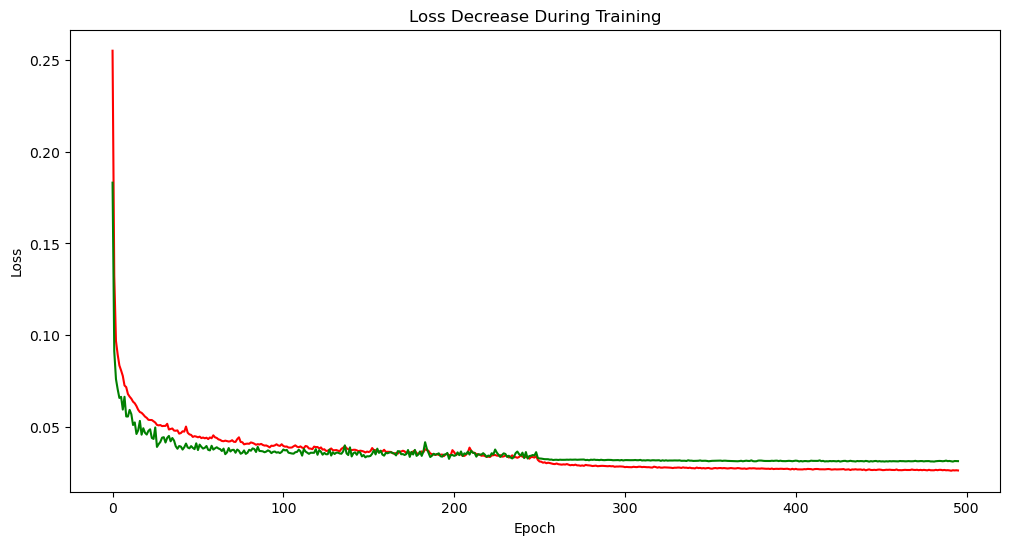

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_loss_list,'r')
plt.plot(val_loss_list,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Decrease During Training")
print('111')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_81824\3306801687.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(test_L[:,1], test_L[:,0], color='blue', label="predict", cmap='viridis', vmin=20, vmax=100)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_81824\3306801687.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(test_P[:,1], test_P[:,0], color='red', label="label", cmap='viridis', vmin=20, vmax=100)


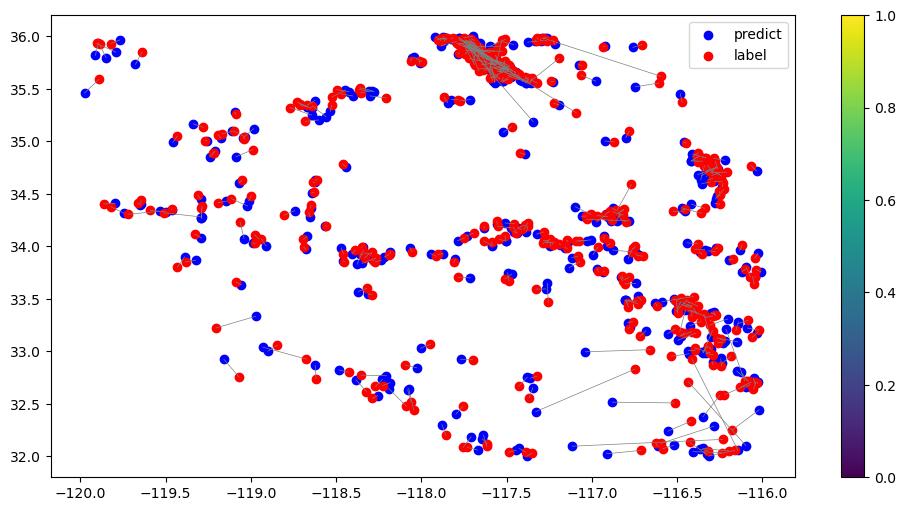

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(test_L[:,1], test_L[:,0], color='blue', label="predict", cmap='viridis', vmin=20, vmax=100)
plt.scatter(test_P[:,1], test_P[:,0], color='red', label="label", cmap='viridis', vmin=20, vmax=100)
for i in range(len(test_L)):
    plt.plot([test_L[i,1], test_P[i,1]], [test_L[i,0], test_P[i,0]], color='gray', linestyle='-', linewidth=0.5)
plt.colorbar()
plt.legend()
plt.show()

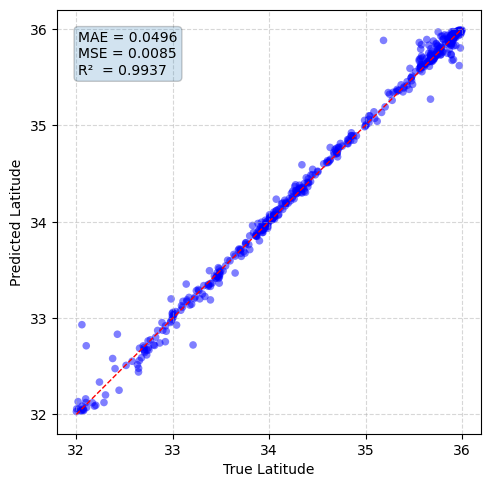

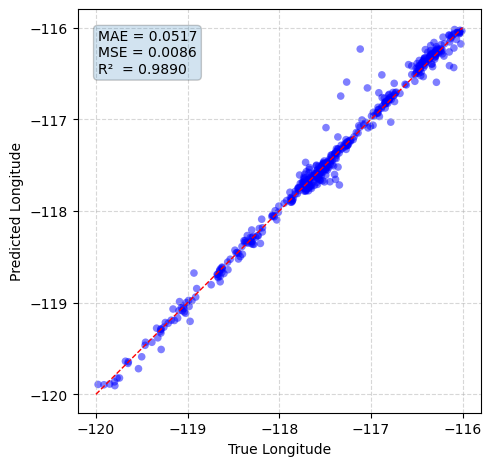

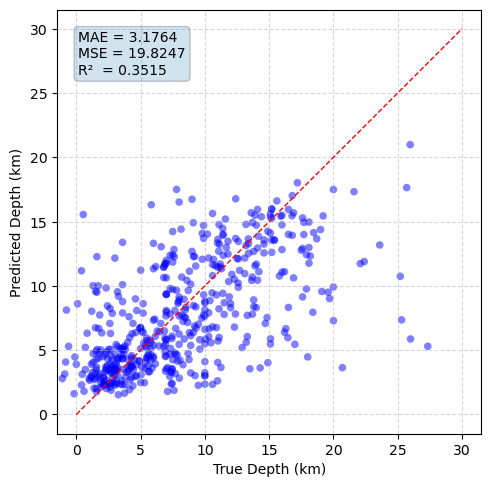

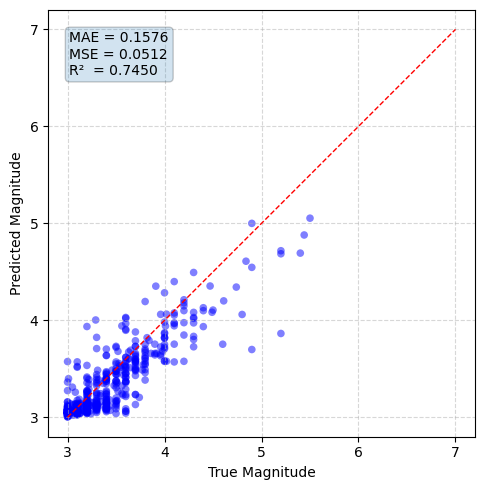

In [14]:
names = ["Latitude", "Longitude", "Depth (km)", "Magnitude"]

def regression_metrics(y_true, y_pred):
    # Mask out NaN/Inf values (commented out for now)
    # mask = np.isfinite(y_true) & np.isfinite(y_pred)
    # yt = y_true[mask]
    # yp = y_pred[mask]
    # if yt.size == 0:
    #     return np.nan, np.nan, np.nan

    # Calculate MAE (Mean Absolute Error)
    mae = np.mean(np.abs(y_true - y_pred))
    # Calculate MSE (Mean Squared Error)
    mse = np.mean((y_true - y_pred) ** 2)
    # Calculate R² (R-squared, returns NaN if variance is zero)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_pred.mean()) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return mae, mse, r2

# Manually defined "range" for each feature (Latitude, Longitude, Depth, Magnitude)
manual_ranges = [
    (32, 36),   # Latitude
    (-120, -116),  # Longitude (note: -120 is placed first to ensure proper range)
    (0, 30),    # Depth (in km)
    (3, 7)      # Magnitude
]

for i in range(4):
    # —— Metrics are calculated using the original, unperturbed data —— #
    x_true = test_L[:, i]  # True values
    y_pred = test_P[:, i]  # Predicted values
    mae, mse, r2 = regression_metrics(x_true, y_pred)

    plt.figure(figsize=(5, 5))

    # Scatter plot of true vs predicted values
    plt.scatter(x_true, y_pred, s=30, alpha=0.5,
                c="blue", marker="o", edgecolors="none")

    # Extract the manually defined range for each feature
    cmin, cmax = manual_ranges[i]
    # Expand the range by 10% on both ends
    pad = 0.05 * (cmax - cmin)
    vmin = cmin - pad
    vmax = cmax + pad

    # Plot y=x diagonal line (within the expanded range)
    plt.plot([cmin, cmax], [cmin, cmax], "r--", linewidth=1)

    # Enforce the axis limits based on the expanded range
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)

    # Labels for the axes
    plt.xlabel(f"True {names[i]}")
    plt.ylabel(f"Predicted {names[i]}")

    # Display the metrics in a box on the plot
    metrics_text = f"MAE = {mae:.4f}\nMSE = {mse:.4f}\nR²  = {r2:.4f}"
    ax = plt.gca()
    ax.text(0.05, 0.95, metrics_text,
            transform=ax.transAxes,
            ha="left", va="top",
            bbox=dict(boxstyle="round", alpha=0.2, pad=0.3))

    # Display grid and set aspect ratio to equal
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')

    # Set axis tickers for better visualization (except for Depth)
    if i != 2:
        import matplotlib.ticker as mticker
        ax = plt.gca()
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(mticker.MultipleLocator(1))

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')  # Equivalent to plt.axis("equal")
    plt.tight_layout()
    # Save the plot as a high-quality image
    plt.savefig(f'California_{i:02d}_{names[i].replace(" ", "_")}.png', dpi=600)
    plt.show()
